# Quantifying local lipid environments

The local environment of a lipid refers to the lipid composition of the patch of membrane surrounding a reference lipid. The local lipid environment can tell us whether there is a preferential aggregation of specific lipid species within a membrane.

We will first look at the local environment of lipids in a DPPC, DOPC, and cholesterol membrane simulated by [Smith et al.](https://www.biorxiv.org/content/10.1101/2021.05.24.445501v3). We will later perform similar calculations for the neuronal plasma membrane studied by [Ingólfsson et al. (2017)](https://www.cell.com/biophysj/fulltext/S0006-3495(17)31132-3).


In [1]:
import pathlib
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import MDAnalysis as mda
from lipyphilic.lib.neighbours import Neighbours


## Load the topology and trajectory using MDAnalysis

In [2]:
u = mda.Universe("../datafiles/dppc-dopc-chol.tpr", "../datafiles/dppc-dopc-chol.xtc")

## Generate a neighbour matrix

Before we quantigy local lipid environments, we must first use **lipyphilic** to construct an adjacency matrix, $A$, that describes whether each pair of lipid molecules are neighbouring one another or not. The neighbour matrix is defined as follows:

- $A_{ij}=1$ if lipid $i$ is neighbouring lipid $j$
- $A_{ij}=0$ otherwise

To construct the neighbour matrix, we will use the class `lipyphilic.lib.neighbours.Neighbours`.

In [3]:
neighbours = Neighbours(
    universe=u,
    lipid_sel="name GL1 GL2 ROH",
    cutoff=12.0
)

The above selection (`lipid_sel=name GL1 GL2 ROH`) will select the glycerol backbone of the phospholipids and the hydroxyl headgroup of cholesterol.

A phospholipid will be considered to be neighbouring a cholesterol molecule if either its *GL1* or *GL2* bead is within *12* Å of the ROH bead of the cholesterol. For neighbouring lipids, the distances between their respective *GL1* and "GL2* beads are be considered; that is, if two phosphoslipids have any of their glycerol backbone beads within *12* Å of one another, they will be considered neighbours.


We then select which frames of the trajectory to analyse (`None` will use every frame) and select to display a progress bar (`verbose=True`):
  

In [4]:
neighbours.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)


  0%|          | 0/51 [00:00<?, ?it/s]

## Accessing the results

The results are stored in the `neighbours.Neighbours` attribute as a NumPy of Compressed Sparse Row matrices.

There is one matrix for each frame used in the analysis:

In [5]:
neighbours.neighbours.size

51

Let's take a look at the first frame:

In [6]:
first_matrix = neighbours.neighbours[0]

In [7]:
first_matrix

<12000x12000 sparse matrix of type '<class 'numpy.int8'>'
	with 120930 stored elements in Compressed Sparse Row format>

This is a scipy Compressed Sparse Row matrix. It has a shape of ($N_{\rm lipids}, N_{\rm lipids}$)


We can extract pairs of neighbouring lipids as follows:

In [8]:
reference, neighbour = first_matrix.nonzero()

In [9]:
print(reference)

[    0     0     0 ... 11999 11999 11999]


In [10]:
print(neighbour)

[  916  2265  3492 ... 10873 11081 11445]


We see that at this first frame, the lipid with residue index 0 is neighbouring lipids 916, 2265, 3492, and so on.

## Calculating the local lipid environment

Once we have constructed our adjacency matrices, we can use the `count_neighbours` helper method to quantify the local environment of each lipid at each frame:

In [11]:
counts = neighbours.count_neighbours()


  0%|          | 0/51 [00:00<?, ?it/s]

`counts` is a Pandas DataFrame in which each row contains the following information:

- lipid residue name
- lipid residue index
- frame number
- number of cholesterol neighbours
- number of DOPC neighbours
- number of DPPC neighbours
- total number of neighbours

Let's take a look at the DataFrame:


In [12]:
counts

,Label,Resindex,Frame,nCHOL,nDOPC,nDPPC,Total
0,CHOL,0,0,3,3,4,10
1,CHOL,0,1,5,4,4,13
2,CHOL,0,2,4,3,4,11
3,CHOL,0,3,3,3,3,9
4,CHOL,0,4,4,3,6,13
...,...,...,...,...,...,...,...
611995,DPPC,11999,46,6,3,4,13
611996,DPPC,11999,47,5,3,3,11
611997,DPPC,11999,48,5,5,3,13
611998,DPPC,11999,49,5,3,4,12


We see that at the first frame, the first cholesterol molecule (residue index 0) has:
- 3 cholesterol neighbours
- 3 DOPC neighbours
- 4 DPPC neighbours
- 10 neighbours in total


## Store the reuslts
There are a couple of ways of storing the results from the analysis.

Well store the results in the following directory:

In [13]:
results_directory = pathlib.Path(
    "../results/neighbours"
)

# Create the directory if it doesn't already exist
results_directory.resolve().mkdir(exist_ok=True, parents=True)


1. You can persist the `Neighbours` object using pickle

In [14]:
# Location to store the results
filename = results_directory.joinpath("neighbours-dppc-dopc-chol.pkl")
print(filename)

../results/neighbours/neighbours-dppc-dopc-chol.pkl


In [15]:
# store the object
with open(filename, 'wb') as f:
    pickle.dump(neighbours, f)
    

In [16]:
# load for later usage
with open(filename, 'rb') as f:
    neighbours = pickle.load(f)


2. You store the pandas DataFrame of the local lipid environment

In [17]:
# Location to store the results
filename = results_directory.joinpath("neighbour-counts-dppc-dopc-chol.h5")
print(filename)

../results/neighbours/neighbour-counts-dppc-dopc-chol.h5


In [18]:
# store the counts DataFrame
counts.to_hdf(
    filename,
    key='df',
    mode='w'
)


In [19]:
# load for later usage
counts = pd.read_hdf(filename)


# Lipid enrichment/depletion index

The `count_neighbours` method will, by default, return the number of neighbouring lipid species around each individual lipid.

However, a clearer picture of aggregation of certain lipid species can be gained by instead considering the [enrichment/depletion index](https://pubs.acs.org/doi/10.1021/ja507832e) of each lipid species. 

The lipid enrichment index of species $B$ around species $A$, $E_{AB}$, may be defined as:
$$
E_{AB} = N_{AB} / \langle N_B \rangle
$$

where $N_{AB}$ is the number of molecules of species $B$ around species $A$, and $\langle N_B \rangle$ is the mean number of species $B$ around any species.

To calculate the enrichment/depletion index of each species at each frame, as well as the raw neighbour counts, we can set the `return_enrichment` keyword to `True` when we call `count_neighbours`:

In [20]:
counts, enrichment = neighbours.count_neighbours(return_enrichment=True)

  0%|          | 0/51 [00:00<?, ?it/s]

This will return two Pandas DataFrames, one containing the neighbour counts and the other the enrichment/depletion index of each species at each frame. 

`enrichment` contains the following information for each row:

- lipid species
- frame number
- enrichment of cholesterol
- enrichment of DOPC
- enrichment of DPPC

Let's take a look at the DataFrame:


In [21]:
enrichment

,Label,Frame,feCHOL,feDOPC,feDPPC
0,CHOL,0,0.859953,0.934876,1.010086
1,CHOL,1,0.855300,0.937632,1.009027
2,CHOL,2,0.867951,0.934240,1.008378
3,CHOL,3,0.861744,0.939086,1.011233
4,CHOL,4,0.855374,0.938745,1.007719
...,...,...,...,...,...
148,DPPC,46,1.150928,0.981446,1.080921
149,DPPC,47,1.151835,0.988319,1.079786
150,DPPC,48,1.145993,0.983084,1.086685
151,DPPC,49,1.152031,0.987859,1.079485


**Values:**
- **below 1 correspond to depletion**
- **above 1 correspond to enrichment**


We see that at the first frame, the local environment of cholesterol is:
- depleted of cholesterol and DOPC
- enriched in DPPC

At the final frame, the local lipid environment of DPPC is:
- enriched in cholesterol and DPPC
- slightly depleted of DOPC


## Plot the enrichment over time

As we know the enrichment at each frame, we can plot the time-evolution of the enrichment/depletion index to see whether particular species form aggregates over time.


### Plotting with Pandas

In [22]:
# Get a list of the species in the membrane
unique_labels = counts.Label.unique()

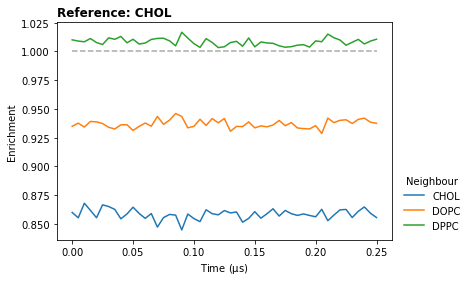

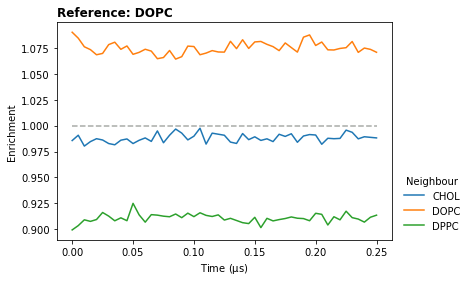

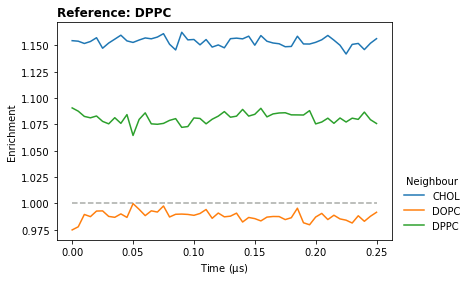

In [23]:
# iterate over each species
for ref in unique_labels:
    
    # get the enrichment of the current species
    species_fe = enrichment.loc[enrichment.Label == ref].copy()
    
    # For plotting, we need to know the times used in the analysis
    ps_to_microseconds = 1e-6
    species_fe["Time"] = species_fe["Frame"].values * neighbours._trajectory.dt * ps_to_microseconds
    
    # For the current species, plot the enrichment of each other species over time
    species_fe.plot.line(
        x=r"Time",
        y=[f"fe{l}" for l in unique_labels],
        xlabel=r"Time ($\rm \mu s$)",
        ylabel="Enrichment"
    )
    
    # Add label info
    plt.title(f"Reference: {ref}", loc="left", weight="bold")
    plt.legend(unique_labels, loc="lower left", bbox_to_anchor=(1.01, 0.0), frameon=False, title="Neighbour")
    
    plt.hlines(y=1.0, xmin=0, xmax=0.25, linestyle="--", color="xkcd:grey", alpha=0.8)
    plt.show()
    

The trajectory we are using is a 250 ns time period from 7.75 µs to 8.0 µs. By this point, cholesterol and DPPC have demixed somewhat from DOPC, whilst DOPC has self-aggregated.

# Counting the number of $L_d$ or $L_o$ neighbours

Instead of using the lipid resname to identify neighbouring lipids, any ordinal data may be used for counting lipid neighbours. This is done through use of the `count_by` and `count_by_labels` parameters.

[In another tutorial](HiddenMarkovModel.ipynb), we construct a hidden Markov model based on lipid thicknesses in order to determine whether each lipid in each frame is liquid-ordered ($L_o$) or liquid-disordered ($L_d$). We will use this information here in order to quantify to local lipid environments.


In [24]:
# Load the lipid order data
filename = "../results/HMM/lipid-order.npy"
lipid_order = np.load(filename)


`lipid_order` is a two-dimensional NumPy. Like many analyses in **lipyphilic**, the array is of shape ($N_{\rm lipids}$, $N_{\rm lipids}$) The:

- rows correspond to individual lipids
- columns correspond to individual frames.

In the array, the ordered state of each lipid is defined as follows:

- values of 1 indicate the lipid is in the $Ld$ state
- values of -1 indicate the lipid is in the $Ld$ state

Let's look at the array:


In [25]:
lipid_order

array([[ 1,  1,  1, ...,  1,  1,  1],
       [ 1,  1,  1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1],
       ...,
       [ 1,  1,  1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 1,  1,  1, ...,  1,  1,  1]], dtype=int8)

We see the first lipid (first row) is $L_o$ both at the beginning and end of the frames used in the analysis.

The second lipid (second row) is $L_o$ at the beginning of the analysis but $L_d$ at the end.



## Pass the lipid order data to `count_neighbours`

Because `lipid_order` has shape $N_{\rm lipids}$, $N_{\rm lipids}$, we can pass this NumPy as input to `count_neighbours`. `count_neighbours` will then use the lipid order data to define local lipid environments:


In [26]:
counts = neighbours.count_neighbours(
    count_by=lipid_order,
    count_by_labels={'Ld': -1, 'Lo': 1}  # tell count_neighbours that -1 and 1 correspond to Ld and Lo respectively
)

  0%|          | 0/51 [00:00<?, ?it/s]

As before, `counts` is a Pandas DataFrame.

However, this time, each row contains the following information:

- lipid order ($L_d$ or $L_o$)
- lipid residue index
- frame number
- number of $L_d$ neighbours
- number of $L_o$ neighbours

Let's take a look at the DataFrame:

    

In [27]:
counts

,Label,Resindex,Frame,nLd,nLo,Total
0,Lo,0,0,3,7,10
1,Lo,0,1,4,9,13
2,Lo,0,2,3,8,11
3,Lo,0,3,2,7,9
4,Lo,0,4,3,10,13
...,...,...,...,...,...,...
611995,Lo,11999,46,1,12,13
611996,Lo,11999,47,0,11,11
611997,Lo,11999,48,1,12,13
611998,Lo,11999,49,1,11,12


At the first frame, the lipid with residue index 0 is in the $L_o$ state. It has 3 $L_d$, neighbours, 7 $L_o$ neighbours, and 10 neighbours in total.

## Enrichment/depletion of $L_d$ or $L_o$ lipids

As before, we can set `return_enrichment=True` to obtain the enrichment at each frame:

In [28]:
counts, enrichment = neighbours.count_neighbours(
    count_by=lipid_order,
    count_by_labels={'Ld': -1, 'Lo': 1},  # tell count_neighbours that -1 and 1 correspond to Ld and Lo respectively
    return_enrichment=True
)

  0%|          | 0/51 [00:00<?, ?it/s]

`enrichment` is a Pandas Dataframe that contains the enrichment/depletion index of each ordered state.

`enrichment` contains the following information for each row:

- lipid order ($L_d$ or $L_o$)
- frame number
- enrichment of $L_d$
- depletion of $L_o$


In [29]:
enrichment

,Label,Frame,feLd,feLo
0,Ld,0,1.640676,0.277070
1,Ld,1,1.650601,0.274862
2,Ld,2,1.665972,0.268376
3,Ld,3,1.691819,0.254275
4,Ld,4,1.708444,0.244885
...,...,...,...,...
97,Lo,46,0.292695,1.741305
98,Lo,47,0.304764,1.743736
99,Lo,48,0.309728,1.746055
100,Lo,49,0.315786,1.746665


# More complex mixtures

The construction of the neighbour matrix, and quantification of local lipid environments, makes use of the powerful selection language of MDAnalysis. This means local lipid environments can readily be calculated even for membranes with highly complex compositions.

Below we will quantigy to local lipid environment for each species in the 58-component neuronal plasma membrane studied by [Ingólfsson et al. (2017)](https://www.cell.com/biophysj/fulltext/S0006-3495(17)31132-3).


In [30]:
u = mda.Universe("../datafiles/LIM25_neuronal_plasma_membrane.gro")

/home/paul/git-repos/mdanalysis/package/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: A
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/paul/git-repos/mdanalysis/package/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: D
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/paul/git-repos/mdanalysis/package/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: G
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/paul/git-repos/mdanalysis/package/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: R
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
/home/paul/git-repos/mdanalysis/

In [31]:
membrane = u.select_atoms("name GL1 GL2 AM1 AM2 ROH").residues

The above selects all lipids in our system:

In [32]:
print(f"Number of lipids: {membrane.n_residues}")
print(f"Number of lipid species: {np.unique(membrane.resnames).size}")

Number of lipids: 19447
Number of lipid species: 58


## Generate the neighbour matrix


In [33]:
# lipid_sel cover all 58 species in the membrane
neighbours = Neighbours(
    universe=u,
    lipid_sel="name GL1 GL2 AM1 AM2 ROH",
    cutoff=12.0
)


In [34]:
# Construct the neighbour matrix
neighbours.run(
    start=None,
    stop=None,
    step=None,
    verbose=True
)


  0%|          | 0/1 [00:00<?, ?it/s]

/home/paul/git-repos/mdanalysis/package/MDAnalysis/coordinates/base.py:887: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


## Get the neighbour counts and enrichment/depletion of each lipid species

In [35]:
counts, enrichment = neighbours.count_neighbours(
    return_enrichment=True
)

  0%|          | 0/1 [00:00<?, ?it/s]

`counts` contains the number of each species around each individual lipid at each frame.

In [36]:
counts.head()

,Label,Resindex,Frame,nCHOL,nDBCE,nDBG1,nDBG3,nDBGS,nDOPC,nDPCE,...,nPOPE,nPOPI,nPOPS,nPOSM,nPUPC,nPUPE,nPUPI,nPUPS,nPWPC,Total
0,CHOL,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,7
1,CHOL,1,0,3,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,10
2,CHOL,2,0,5,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,11
3,CHOL,3,0,5,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,0,10
4,CHOL,4,0,1,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,4


`enrichment` containts the enrichment/depletion index for each species at each frame

In [37]:
enrichment.head()

,Label,Frame,feCHOL,feDBCE,feDBG1,feDBG3,feDBGS,feDOPC,feDPCE,feDPG1,...,fePOPC,fePOPE,fePOPI,fePOPS,fePOSM,fePUPC,fePUPE,fePUPI,fePUPS,fePWPC
0,CHOL,0,0.813804,1.020109,1.035580,0.979078,1.022706,0.975603,0.989185,0.949647,...,0.992482,0.995661,0.949569,0.984684,0.948808,0.936670,0.935348,0.951896,0.917778,0.955743
1,DBCE,0,1.401415,0.000000,0.000000,8.022690,0.000000,1.393052,1.902093,0.000000,...,1.028579,1.220319,1.249486,2.646931,0.000000,0.697025,0.615162,1.808687,0.000000,0.000000
2,DBG1,0,1.543746,0.000000,11.916054,6.017017,9.104401,0.000000,1.426570,14.482757,...,0.514289,0.305080,0.000000,0.000000,0.000000,0.522769,0.092274,0.000000,0.000000,1.408386
3,DBG3,0,1.445209,8.620124,5.958027,0.000000,1.138050,1.741314,1.426570,13.368698,...,0.428575,0.915239,0.000000,0.000000,1.295776,0.000000,0.369097,0.000000,0.000000,0.000000
4,DBGS,0,1.418933,0.000000,8.473638,1.069692,5.260320,1.114441,0.253612,9.308575,...,1.020960,0.705073,0.000000,0.000000,1.842881,0.743493,0.459321,0.000000,0.000000,1.001519


## Plot a heatmap of the lipid enrichment/depletion

In [38]:
# Average the enricment values over time
# Extract the enrichment value into a two-dimensional NumPy array
enrichment_values = enrichment.groupby("Label")[enrichment.columns[2:]].mean().values

In [39]:
# There is an enrichment value for each species around each other species
enrichment_values.shape

(58, 58)

In [40]:
# Extract the species residue names to label our heatmap
labels = np.asarray([column.strip("fe") for column in enrichment.columns if column.startswith("fe")])

In [41]:
# This is a NumPy array containing each species name in the same order as seen in the enrichment DataFrame
labels

array(['CHOL', 'DBCE', 'DBG1', 'DBG3', 'DBGS', 'DOPC', 'DPCE', 'DPG1',
       'DPG3', 'DPGS', 'DPPC', 'DPPS', 'DPSM', 'I0PC', 'I0PE', 'OAPE',
       'OIPC', 'OIPE', 'OUPC', 'OUPE', 'OUPS', 'P0PC', 'P0PE', 'PADG',
       'PAI1', 'PAI6', 'PAI7', 'PAPA', 'PAPC', 'PAPE', 'PAPI', 'PAPS',
       'PBSM', 'PIPI', 'PNCE', 'PNG1', 'PNG3', 'PNGS', 'PNSM', 'POCE',
       'PODG', 'POG1', 'POG3', 'POGS', 'POI1', 'POI6', 'POI7', 'POPA',
       'POPC', 'POPE', 'POPI', 'POPS', 'POSM', 'PUPC', 'PUPE', 'PUPI',
       'PUPS', 'PWPC'], dtype='<U4')

Now we can create our heatmap:

Text(424.0, 0.5, 'Reference')

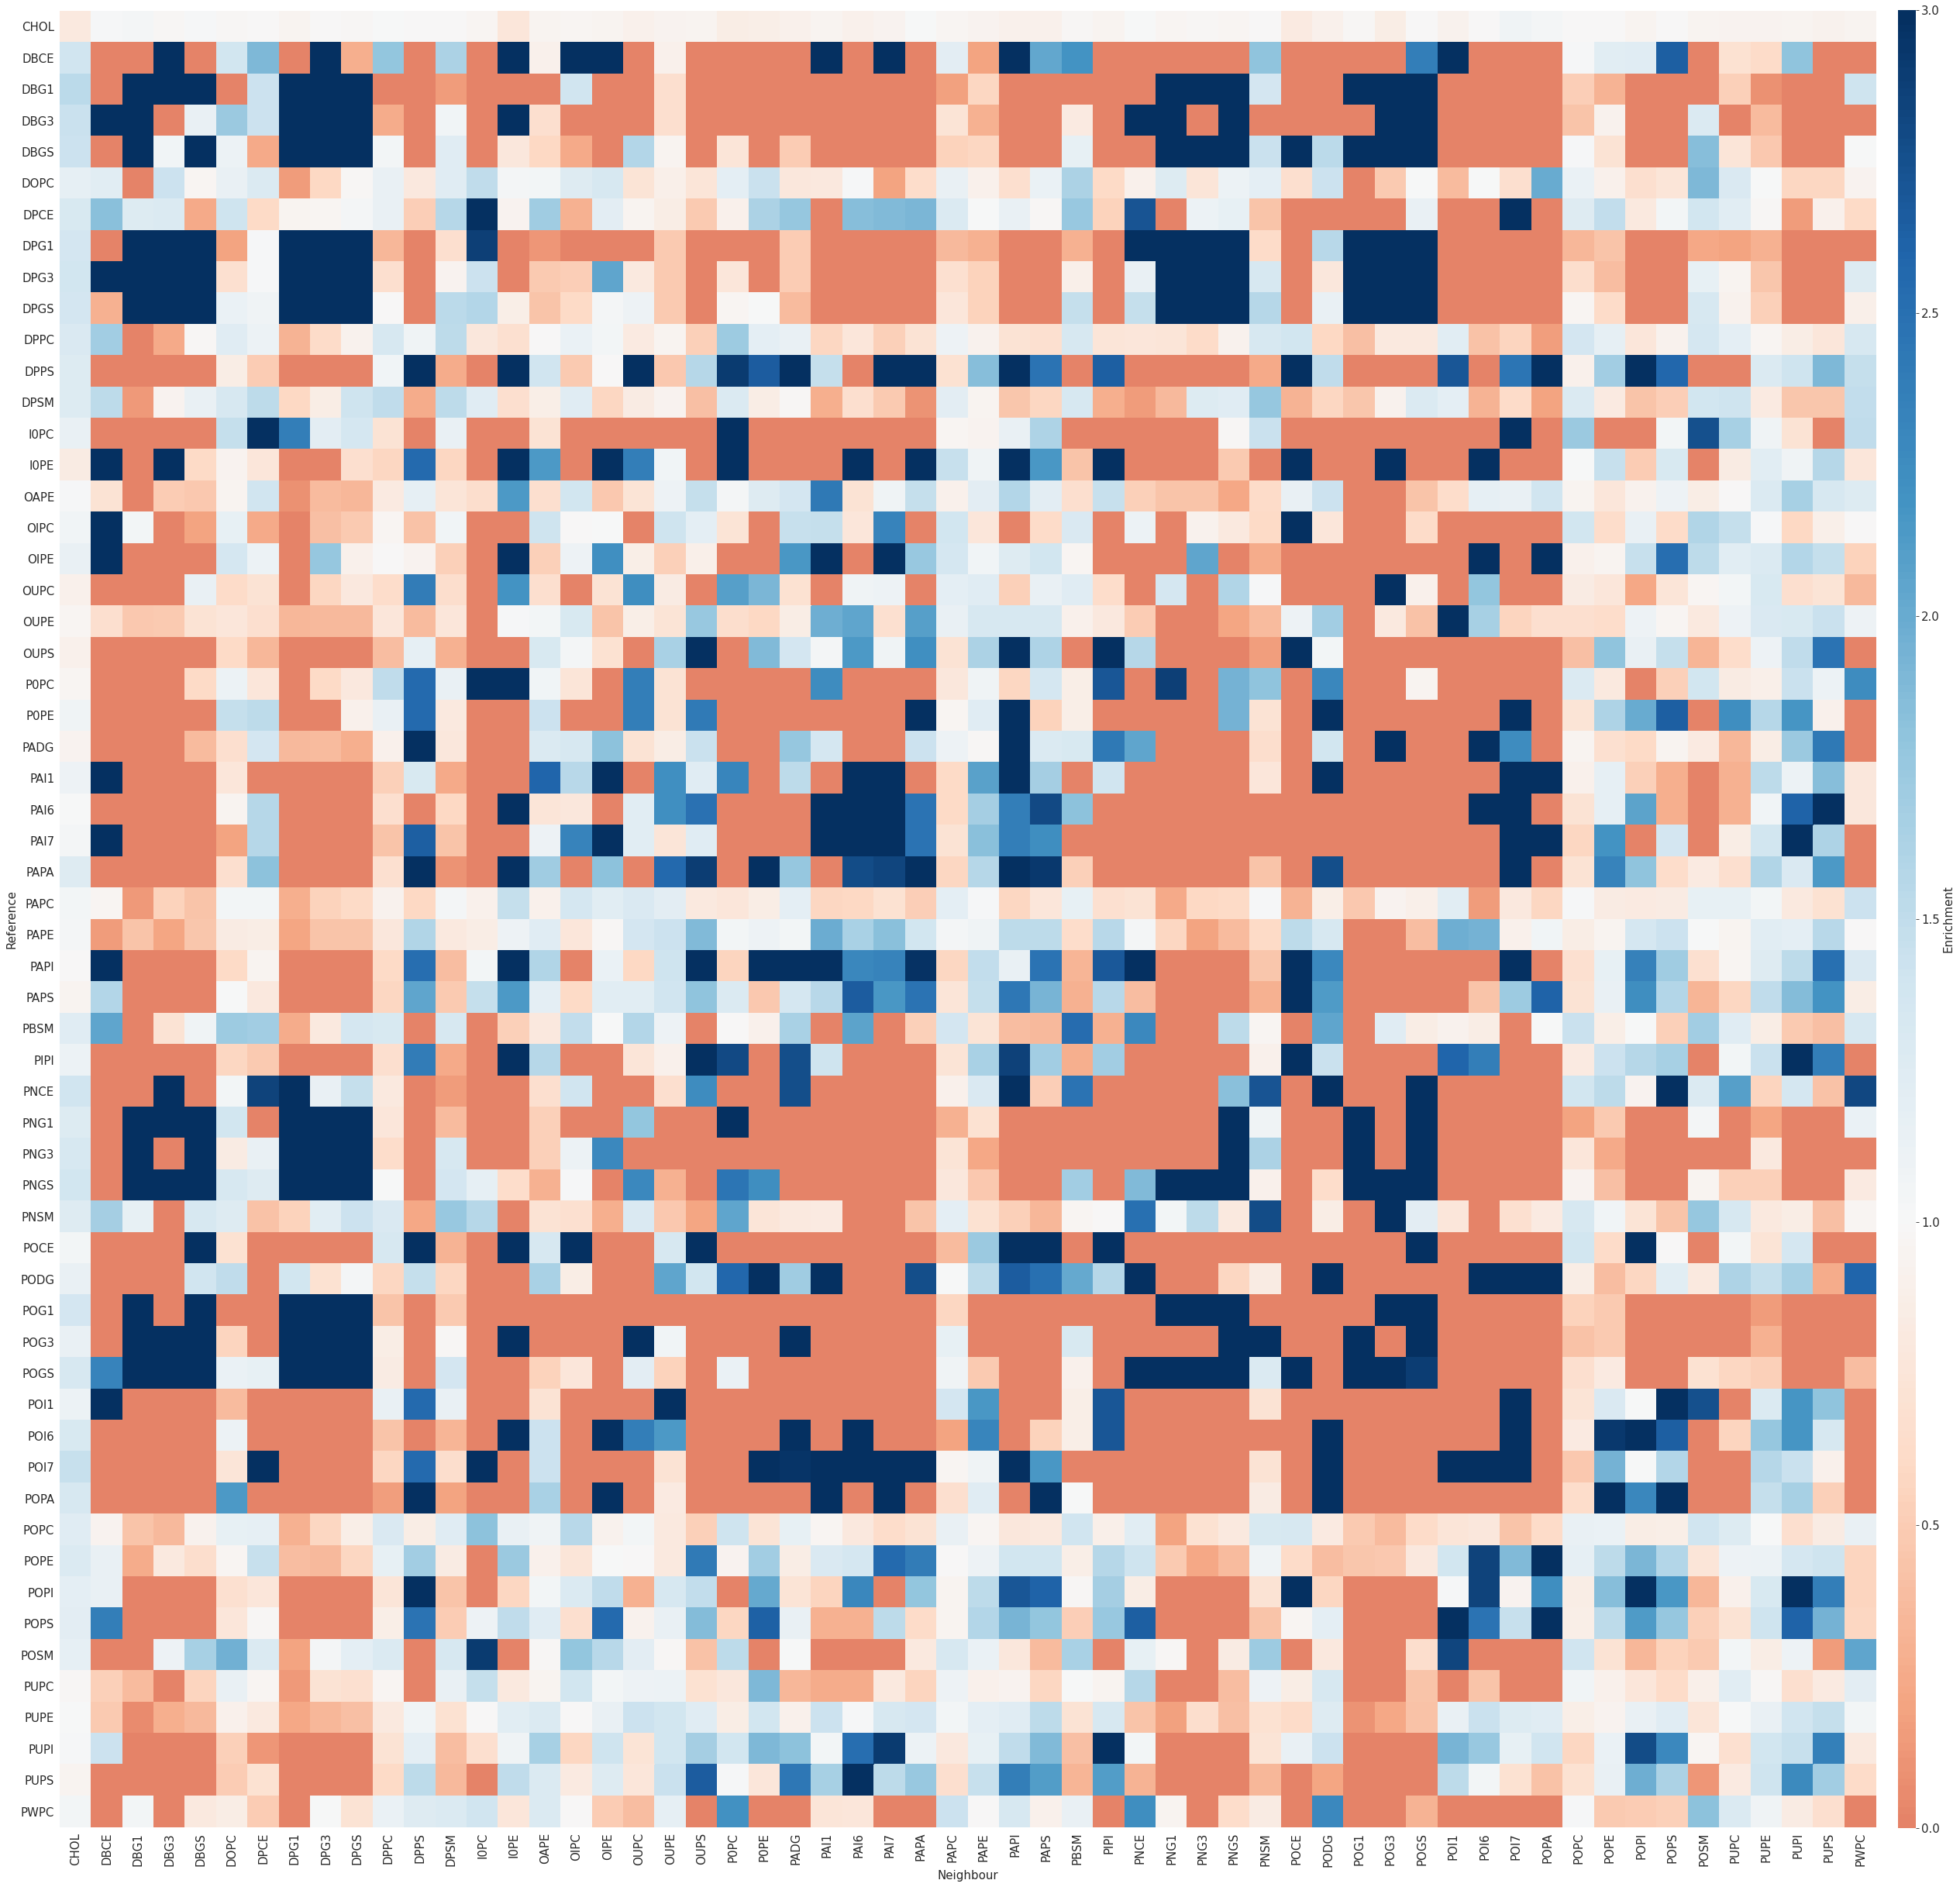

In [42]:
# Create a huge figure large enough for our 58 x 58 matrix
plt.figure(figsize=(50, 50))
sns.set({"font.size": 15})

sns.heatmap(
    enrichment_values,
    xticklabels=labels,
    yticklabels=labels,
    vmin=0, vmax=3, center=1,
    annot=False, fmt=".1f",
    square=True,
    cmap="RdBu",
    cbar=True,
    cbar_kws={"label": "Enrichment", "aspect":100, "shrink": 0.863, "pad": 0.01}
)

plt.xlabel("Neighbour")
plt.ylabel("Reference")


## Plotting enrichment by tail saturation
The above heatmap, which plots the enrichment of each species around every other species, contains too much information to be of much use.

Here, we will instead calculate the enrichment of lipids based on how saturated their tails are.


In [43]:
lipids = np.asarray([column.strip("fe") for column in enrichment.columns if column.startswith("fe")])

First we need to define the saturation of each lipid:

In [44]:
membrane = u.select_atoms("name GL1 GL2 AM1 AM2 ROH")
saturation = []

# Determine the saturation of each individual lipid
for lipid in np.unique(membrane.resnames):
    
    # select only the lipids of the current species
    lipid_residues = membrane.residues.atoms.select_atoms(f"resname {lipid}").residues
    
    # now we will consider a single lipid of this species to determine its saturation
    lipid_atoms = lipid_residues[0].atoms
    
    # It is a sterol if it has an ROH bead
    if "ROH" in lipid_atoms.names:
        saturation.append("Chol")
    
    else:
        
        # count the number of D beads - these refer to double bonds in the acyl tails
        num_doulbe = sum([True for name in lipid_atoms.names if name.startswith("D")])
        
        # It is saturated if it has no D beads
        if num_doulbe == 0:
            saturation.append("S")
            
        # It is monounsaturated if it has 1 D bead
        elif num_doulbe == 1:
            saturation.append("MU")
            
        # It is polyunsaturated if it has 2+ D beads
        else:
            saturation.append("PU")

saturation = np.array(saturation)


Now we will create a two-dimensional NumPy array, of shape ($N_{\rm lipids}, N_{\rm frames}$), where each lipid is labelled by its saturation.


In [45]:
count_by = np.full((membrane.n_residues, neighbours.n_frames), fill_value="", dtype="<U4")

for lipid, sat in zip(np.unique(membrane.resnames), saturation):
    
    lipid_indices = membrane.residues.resnames == lipid
    count_by[lipid_indices] = sat


We can now pass this `count_by` array to `count_neighbours`

In [46]:
counts, enrichment = neighbours.count_neighbours(
    count_by=count_by,
    return_enrichment=True
)

  0%|          | 0/1 [00:00<?, ?it/s]

Let's looks at the DataFrames:

In [47]:
counts.head()

,Label,Resindex,Frame,nChol,nMU,nPU,nS,Total
0,Chol,0,0,2,2,3,0,7
1,Chol,1,0,3,3,3,1,10
2,Chol,2,0,5,0,4,2,11
3,Chol,3,0,5,3,1,1,10
4,Chol,4,0,1,1,2,0,4


In [48]:
enrichment.head()

,Label,Frame,feChol,feMU,fePU,feS
0,Chol,0,0.813804,0.985810,0.938814,0.989275
1,MU,0,1.249158,1.113471,1.029335,1.120257
2,PU,0,1.025237,0.886986,1.171226,0.670346
3,S,0,1.309441,1.170115,0.812664,1.606033


Now we can plot enrichment in terms of tail saturation

In [49]:
# Average the enricment values over time
# Extract the enrichment value into a two-dimensional NumPy array
enrichment_values = enrichment.groupby("Label")[enrichment.columns[2:]].mean().values

In [50]:
# This is now a NumPy that contains the enrichment/depletion in terms of tail saturation
enrichment_values

array([[0.81380427, 0.98580965, 0.93881364, 0.98927531],
       [1.24915828, 1.1134714 , 1.0293349 , 1.12025653],
       [1.02523664, 0.88698551, 1.17122624, 0.67034623],
       [1.30944063, 1.17011531, 0.81266381, 1.60603278]])

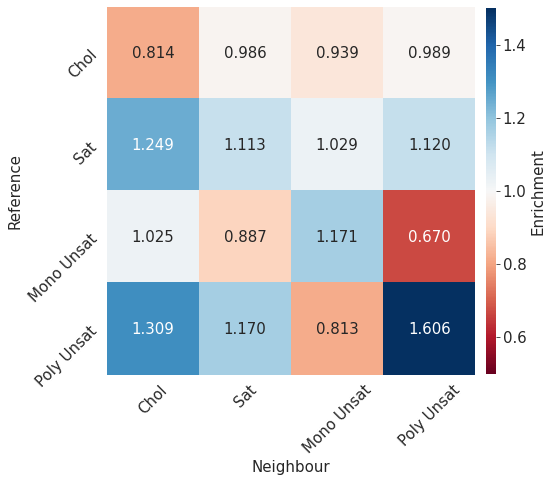

In [51]:
ticklabels = ["Chol", "Sat", "Mono Unsat", "Poly Unsat"]
plt.figure(figsize=(8, 8))
sns.set({"font.size": 15})

sns.heatmap(
    enrichment_values,
    vmin=0.5, vmax=1.5, center=1,
    annot=True, fmt=".3f",
    square=True,
    cmap="RdBu",
    cbar_kws={"label": "Enrichment", "aspect":40, "shrink": 0.84, "pad": 0.025}
)

plt.xlabel("Neighbour")
plt.ylabel("Reference")

plt.gca().set_xticklabels(ticklabels, rotation=45)
plt.gca().set_yticklabels(ticklabels, rotation=45)

plt.show()
